<h1>Music Recommendation System Using Knowledge Graph</h1>
<blockquotes>This is a full code for developing a Music Recommendation System using Knowledge Graph dan TransM Model</blockquotes>

In [86]:
# Import all necessary packages and libraries
import os
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from collections import Counter 
from dotenv import load_dotenv

load_dotenv()
rng = np.random.default_rng()

<h2>File And Folder Preparation</h2>

In [87]:
dirname = os.getenv('DATASET_FOLDER_PATH')

file_name = {
  "listening_history": "userid-timestamp-artid-artname-traid-traname.tsv",
  "user_data": "userid-profile.tsv",
  "listening_history_parquet": "listening_history.snappy.parquet",
  "user_data_parquet": "user_data.snappy.parquet",
}

In [88]:
user_profile_path = os.path.join(dirname, file_name['user_data_parquet'])
listening_history_path = os.path.join(dirname, file_name['listening_history_parquet'])

graph_filename = os.path.join(dirname, 'knowledge_graph.graphml')

<h2>Get Dataset</h2>
<blockquotes>It is a part of program to fetch the data from Parquet data type and process them before being used in Recommendation System</blockquotes>
<blockquotes>Return 4 Relation in Dataframe<blockquotes>

<h3>Listening History Dataset</h3>
<blockquotes>
Steps
<li>Get Dataset: User - Artist - Track</li>
<li>Select 100 Users</li>
<li>Drop Null Record</li>
<li>Get 3 Relation: listened_to (User-Artist), played (User-Track), and sing (Artist-Track)</li>
<br>
Return: <code>relation_listened_to, relation_played, relation_sing</code> (DataFrame)
</blockquotes>

In [89]:
# Get All Listening History Dataset
df_listening_history_full = pd.read_parquet(listening_history_path)
df_listening_history_full.drop(['timestamp'], inplace=True, axis=1)

print(f'Number of Records: {len(df_listening_history_full):,}\nUnique Users: {df_listening_history_full.user_id.nunique()}\nUnique Artist: {df_listening_history_full.artist_id.nunique():,}')
df_listening_history_full.head(5)

Number of Records: 19,098,853
Unique Users: 992
Unique Artist: 107,295


,user_id,artist_id,artist_name,track_id,track_name
0,user_000001,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,c4633ab1-e715-477f-8685-afa5f2058e42,The Launching Of Big Face
1,user_000001,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,bc2765af-208c-44c5-b3b0-cf597a646660,Zn Zero
2,user_000001,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832,The Return Of Super Barrio - End Credits
3,user_000001,67fb65b5-6589-47f0-9371-8a40eb268dfb,Tommy Guerrero,d9b1c1da-7e47-4f97-a135-77260f2f559d,Mission Flats
4,user_000001,1cfbc7d1-299c-46e6-ba4c-1facb84ba435,Artful Dodger,120bb01c-03e4-465f-94a0-dce5e9fac711,What You Gonna Do?


In [90]:
# Get 100 Users
selected_users = df_listening_history_full.user_id.unique()[::20]

print(f'Random of Unique Users: {len(selected_users)}')

Random of Unique Users: 50


In [91]:
# Listening History Dataset From 100 Users and 120 Tracks of Each User
df_listening_history_selected = df_listening_history_full.loc[df_listening_history_full.user_id.isin(selected_users)].sort_values(['user_id'])
df_listening_history_selected.dropna()
df_listening_history = df_listening_history_selected.groupby('user_id').head(100)

print(f'Number of Records: {len(df_listening_history):,}\nUnique Users: {df_listening_history.user_id.nunique()}\nUnique Artist: {df_listening_history.artist_id.nunique():,}')

Number of Records: 4,909
Unique Users: 50
Unique Artist: 1,296


In [92]:
# Manipulate Columns For 'listened_to' Relation
relation_listened_to = df_listening_history.drop(columns=['artist_id', 'track_id', 'track_name'])
relation_listened_to.dropna(inplace=True)
relation_listened_to.drop_duplicates(inplace=True, ignore_index=True)
relation_listened_to.rename({'user_id': 'head', 'artist_name': 'tail'}, axis=1, inplace=True)
relation_listened_to['relation'] = 'listened_to'

print(f'Number of Records: {len(relation_listened_to):,}\nUnique Users: {relation_listened_to["head"].nunique()}\nUnique Artists: {relation_listened_to["tail"].nunique():,}')
relation_listened_to.head(10)

Number of Records: 1,675
Unique Users: 50
Unique Artists: 1,405


,head,tail,relation
0,user_000001,Plaid & Bob Jaroc,listened_to
1,user_000001,The Matthew Herbert Big Band,listened_to
2,user_000001,Tiefschwarz,listened_to
3,user_000001,Gerber & Kalbata,listened_to
4,user_000001,原田郁子,listened_to
5,user_000001,Jimpster,listened_to
6,user_000001,Gilles Peterson,listened_to
7,user_000001,London Elektricity,listened_to
8,user_000001,Jazzanova Feat. Pedro Martins & Azymuth,listened_to
9,user_000001,Jazzanova Feat. Bémbé Ségué,listened_to


In [93]:
# Manipulate Columns For 'played' Relation
relation_played = df_listening_history.drop(columns=['artist_id', 'artist_name', 'track_id'])
relation_played.dropna(inplace=True)
relation_played.drop_duplicates(inplace=True, ignore_index=True)
relation_played.rename({'user_id': 'head', 'track_name': 'tail'}, axis=1, inplace=True)
relation_played['relation'] = 'played'

print(f'Number of Records: {len(relation_played):,}\nUnique Users: {relation_played["head"].nunique()}\nUnique Tracks: {relation_played["tail"].nunique():,}')
relation_played.head(10)

Number of Records: 3,870
Unique Users: 50
Unique Tracks: 3,737


,head,tail,relation
0,user_000001,The Launching Of Big Face,played
1,user_000001,One Life,played
2,user_000001,Just Swing,played
3,user_000001,The Story,played
4,user_000001,Pontificate,played
5,user_000001,Liquid Cherries,played
6,user_000001,Akropolis,played
7,user_000001,Waiting,played
8,user_000001,Yessness,played
9,user_000001,Battery,played


In [94]:
# Manipulate Columns For 'sing' Relation
relation_sing = df_listening_history.drop(columns=['user_id', 'artist_id', 'track_id'])
relation_sing.dropna(inplace=True)
relation_sing.drop_duplicates(inplace=True, ignore_index=True)
relation_sing.rename({'artist_name': 'head', 'track_name': 'tail'}, axis=1, inplace=True)
relation_sing['relation'] = 'sing'

print(f'Number of Records: {len(relation_sing):,}\nUnique Artists: {relation_sing["head"].nunique()}\nUnique Tracks: {relation_sing["tail"].nunique():,}')
relation_sing.head(10)

Number of Records: 3,786
Unique Artists: 1405
Unique Tracks: 3,737


,head,tail,relation
0,Plaid & Bob Jaroc,The Launching Of Big Face,sing
1,The Matthew Herbert Big Band,One Life,sing
2,The Matthew Herbert Big Band,Just Swing,sing
3,The Matthew Herbert Big Band,The Story,sing
4,The Matthew Herbert Big Band,Pontificate,sing
5,Tiefschwarz,Liquid Cherries,sing
6,Gerber & Kalbata,Akropolis,sing
7,The Matthew Herbert Big Band,Waiting,sing
8,The Matthew Herbert Big Band,Yessness,sing
9,The Matthew Herbert Big Band,Battery,sing


<h3>Users' Background Dataset</h3>
<blockquotes>
Steps
<li>Get Dataset: User - User's Information</li>
<li>Select 100 Users</li>
<li>Create Background ID from combining 3 informations</li>
<li>Get A Relation: has_background (User-Background)</li>
<br>
Return: <code>relation_has_background</code> (DataFrame)</blockquotes>

In [95]:
# Get Dataset From Parquet 
df_user_profile_full = pd.read_parquet(user_profile_path)

print(f'Record Count: {len(df_user_profile_full)}')
df_user_profile_full.head(5)

Record Count: 992


,user_id,gender,age,country
0,user_000001,m,NaN,Japan
1,user_000002,f,NaN,Peru
2,user_000003,m,22.0,United States
3,user_000004,f,NaN,None
4,user_000005,m,NaN,Bulgaria


In [96]:
# Background Dataset From 100 Users
df_user_profile = df_user_profile_full.loc[df_user_profile_full.user_id.isin(selected_users)].reset_index(drop=True)
df_user_profile.dropna()

print(f'Number of Records: {len(df_user_profile):,}\nUnique Users: {df_user_profile.user_id.nunique()}\nAge Range: {df_user_profile.age.min()} - {df_user_profile.age.max()}\nUnique Countries: {df_user_profile.country.nunique()}')

Number of Records: 50
Unique Users: 50
Age Range: 19.0 - 39.0
Unique Countries: 19


In [97]:
# Create Background ID
df_user_profile['background'] = df_user_profile.apply(lambda row: f"{row['gender']} - {row['age']} - {row['country']}", axis=1)
df_user_profile['background_id'] = pd.factorize(df_user_profile['background'])[0]
df_user_profile['background_id'] = 'background_' + df_user_profile['background_id'].astype(str)
df_user_profile['relation'] = 'background_of'

print(f'Number of Records: {len(df_user_profile):,}\nUnique Users: {df_user_profile.user_id.nunique()}\nAge Range: {df_user_profile.age.min()} - {df_user_profile.age.max()}\nUnique Countries: {df_user_profile.country.nunique()}')
df_user_profile.head(10)

Number of Records: 50
Unique Users: 50
Age Range: 19.0 - 39.0
Unique Countries: 19


,user_id,gender,age,country,background,background_id,relation
0,user_000001,m,NaN,Japan,m - nan - Japan,background_0,background_of
1,user_000021,m,27.0,Canada,m - 27.0 - Canada,background_1,background_of
2,user_000041,m,30.0,Sweden,m - 30.0 - Sweden,background_2,background_of
3,user_000061,None,NaN,None,None - nan - None,background_3,background_of
4,user_000081,f,34.0,United States,f - 34.0 - United States,background_4,background_of
5,user_000101,m,29.0,United Kingdom,m - 29.0 - United Kingdom,background_5,background_of
6,user_000121,f,NaN,United Kingdom,f - nan - United Kingdom,background_6,background_of
7,user_000141,f,21.0,Trinidad and Tobago,f - 21.0 - Trinidad and Tobago,background_7,background_of
8,user_000161,None,26.0,Netherlands,None - 26.0 - Netherlands,background_8,background_of
9,user_000181,f,19.0,United States,f - 19.0 - United States,background_9,background_of


In [98]:
# Manipulate Columns For 'has_background' Relation
relation_has_background = df_user_profile.drop(['gender', 'age', 'country', 'background'], axis=1)
relation_has_background.rename({'user_id': 'tail', 'background_id': 'head'}, axis=1, inplace=True)
relation_has_background = relation_has_background.iloc[:, [1, 0, 2]]

print(f'Number of Records: {len(df_user_profile):,}\nUnique Users: {df_user_profile.user_id.nunique()}\nAge Range: {df_user_profile.age.min()} - {df_user_profile.age.max()}\nUnique Countries: {df_user_profile.country.nunique()}')
relation_has_background.head(5)

Number of Records: 50
Unique Users: 50
Age Range: 19.0 - 39.0
Unique Countries: 19


,head,tail,relation
0,background_0,user_000001,background_of
1,background_1,user_000021,background_of
2,background_2,user_000041,background_of
3,background_3,user_000061,background_of
4,background_4,user_000081,background_of


<h2>Graph Builder</h2>
<blockquotes>
It is a code for converting dataset become Knowledge Graph
<br>
Return: <code>edges_list</code> (Dataframe) and <code>'knowledge_graph.graphml'</code> GraphML file
</blockquotes>

In [99]:
# Concatinate 4 Relation for Creating List of Edges of Knowledge Graph
graph_data = [relation_has_background, relation_listened_to, relation_played, relation_sing]
edges_list = pd.concat(graph_data, ignore_index=True)
edges_list.dropna(inplace=True)

print(f'Number of Records: {len(edges_list)}')
edges_list.head(10)

Number of Records: 9381


,head,tail,relation
0,background_0,user_000001,background_of
1,background_1,user_000021,background_of
2,background_2,user_000041,background_of
3,background_3,user_000061,background_of
4,background_4,user_000081,background_of
5,background_5,user_000101,background_of
6,background_6,user_000121,background_of
7,background_7,user_000141,background_of
8,background_8,user_000161,background_of
9,background_9,user_000181,background_of


In [100]:
# Creating Graph using Networkx Packages
graph = nx.from_pandas_edgelist(edges_list, 'head', 'tail', 'relation')

In [101]:
# Get Graph Visualization in GraphML File (Open: Gephi Tools)
nx.write_graphml_lxml(graph, graph_filename)

<h2>Graph Embedding</h2>
<blockquotes>It is the main part of music recommendation system which is creating vectors in n-dimensional of entities and relations.</blockquotes><br>
<blockquotes><b>Input: </b><code>graph</code> (Networkx Graph)<blockquotes><br>
<blockquotes><b>Output: </b><br>
<code>entity_embeddings relation_embeddings</code> (Dictionary)<blockquotes><br>
<code>musics_kdtree users_kdtree</code> (K-D Tree)<blockquotes><br>

In [102]:
# Hyperparameter

preparation_hp = {
    "dimension": 30,
    "batch_size": 200
}

transm_hp = {
    "margin": 0.5,
    "learning_rate": 0.1,
    "epochs": 100,
    "n_neg_triplet": 2
}


<h3>Data Preparation</h3>
<blockquotes>In data preparation, the program will prepare and manipulate data so the TransM Model can use them as input. 
<br>
Steps:
<li>Get Triplet from Graph</li>
<li>Calculate Degree of Mapping of Relations</li>
<li>Initialize Embedding</li>
<li>Normalize Embedding</li>
<li>Group Triplets by Its Relation</li>
</blockquotes>

In [103]:
# ===== Define Necessary Functions =====
# Getting Triplets
def get_triplets(graph):
    triplets = [(u, graph[u][v]['relation'], v) for u, v in graph.edges]
    return triplets

# Weighting Relation
def get_mapping_degree(triplets):
    relations = list()
    relation_weights = dict()
    for triplet in triplets:
        if triplet[1] not in relations:
            relations.append(triplet[1])
    
    for relation in relations:
        num_triplets = 0
        distinc_heads = set({})
        distinc_tails = set({})
        for triplet in triplets:
            if triplet[1] == relation:
                num_triplets += 1
                distinc_heads.add(triplet[0])
                distinc_tails.add(triplet[2])
        weight = 1 / np.log10((num_triplets / len(distinc_heads)) + (num_triplets / len(distinc_tails)))
        relation_weights[relation] = weight

    return relation_weights

# L2-Norm
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

# Initialize Vector
def initialize_embedding(objects, embedding_dim):
    limit = 6 / np.sqrt(embedding_dim)
    embedding_result = {}
    for object in objects:
        embedding_result[object] = rng.uniform(-limit, limit, embedding_dim)
    
    return embedding_result

# Relation Grouping
def group_by_relation(triplets, relations):
    grouped_triplets = {relation: [] for relation in relations}
    for triplet in triplets:
        _, relation, _ = triplet
        grouped_triplets[relation].append(triplet)
    
    return list(grouped_triplets.values())

# Spliting Dataset
def split_dataset(grouped_triplets, batch_size):
    split_batches = []
    for group in grouped_triplets:
        for i in range(0, len(group), batch_size):
            split_batches.append(group[i:i + batch_size])

    return split_batches

In [104]:
# ===== Call Function =====
# Get Triplets
triplets = get_triplets(graph)

# Get All Entities and Relations
entities_list = set([str(triplet[0]) for triplet in triplets] + [str(triplet[2]) for triplet in triplets])
relations_list = set([triplet[1] for triplet in triplets])

# Initialize Embedding for Entities and Relations
initial_entities = initialize_embedding(entities_list, preparation_hp["dimension"])
initial_relations = initialize_embedding(relations_list, preparation_hp["dimension"])

# Normalize Embedding Using L2-Norm
entity_normalized = {entity: normalize_vector(embedding) for entity, embedding in initial_entities.items()}
relation_normalized = {relation: normalize_vector(embedding) for relation, embedding in initial_relations.items()}

# Group Triplets
grouped_triplet = group_by_relation(triplets, relations_list)
triplet_batches = split_dataset(grouped_triplet, preparation_hp['batch_size'])

# Get Relation Weight (Degree of Mapping)
relation_weights = get_mapping_degree(triplets)

<h3>TransM Model</h3>
<blockquotes>It is the representaion learning program</blockquotes>

In [105]:
# ===== Define Necessary Functions =====
# Negative Triplet Generator
def _generate_negative_triplet(triplet, entity_embeddings, corrupt_tail=True):
    head, relation, tail = triplet
    if corrupt_tail:
        corrupted_tail = tail
        while corrupted_tail == tail: 
            corrupted_tail = rng.choice(list(entity_embeddings.keys()))
        negative_triplet = (head, relation, corrupted_tail)
    else:
        corrupted_head = head
        while corrupted_head == head:  
            corrupted_head = rng.choice(list(entity_embeddings.keys()))
        negative_triplet = (corrupted_head, relation, tail)

    return negative_triplet

# Scoring Function
def _get_score(head, relation, tail, weight):
    l2_distance = np.linalg.norm(head + relation - tail)
    return weight * l2_distance

# Loss Function
def _get_loss(margin, pos_score, neg_score):
    return max(0, margin + pos_score - neg_score)

# Gradient Calculator
def _calculate_gradient(head, relation, tail, weight):
    return np.array([(2 * weight * (head[i] + relation[i] - tail[i])) for i in range(len(head))])

# TransM Model
def transm_model(all_triplets, entity_embeddings, relation_embeddings, relation_weights, learning_rate, margin, epochs, n_neg_triplet):
    total_loss = 0
    for index, triplet_batches in enumerate(all_triplets):
        batch_loss = 0
        for epoch in range(epochs):
            batch_loss = 0
            for valid_triplet in triplet_batches:
                head, relation, tail = valid_triplet

                negative_triplet_tail = [_generate_negative_triplet(valid_triplet, entity_embeddings) for _ in range(int(n_neg_triplet / 2))]
                negative_triplet_head = [_generate_negative_triplet(valid_triplet, entity_embeddings, False) for _ in range(int(n_neg_triplet /   2))]
                negative_triplet = negative_triplet_head + negative_triplet_tail

                positive_score = _get_score(entity_embeddings[head], relation_embeddings[relation], entity_embeddings[tail], relation_weights[relation])
                negative_score = [_get_score(entity_embeddings[negative_triplet[i][0]], relation_embeddings[negative_triplet[i][1]], 
                                             entity_embeddings[negative_triplet[i][2]], relation_weights[relation]) for i in range(len(negative_triplet))]

                loss = sum(_get_loss(margin, positive_score, negative_score[i]) for i in range(len(negative_score)))
                batch_loss += loss

                if loss > 0:
                    gradient = _calculate_gradient(entity_embeddings[head], relation_embeddings[relation], 
                                                   entity_embeddings[tail], relation_weights[relation])
                    entity_embeddings[head] -= learning_rate * gradient
                    entity_embeddings[tail] += learning_rate * gradient

                    entity_embeddings[head] = normalize_vector(entity_embeddings[head])
                    entity_embeddings[tail] = normalize_vector(entity_embeddings[tail])

            if batch_loss == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch: {index+1}, Loss: {batch_loss} - Training stopped early.')
                break

            if epoch == epochs - 1:
                print(f'Epoch {epoch+1}/{epochs}, Batch: {index+1}, Loss: {batch_loss} - Training finished.')


        total_loss += batch_loss

    print(f'✅ Embedding Completed!, Loss: {total_loss}, Average Loss: {total_loss / len(all_triplets)}')

    return entity_embeddings, relation_embeddings


In [106]:
entity_embeddings, relation_embeddings = transm_model(triplet_batches, entity_normalized, relation_normalized, relation_weights, transm_hp["learning_rate"], transm_hp["margin"], transm_hp['epochs'], transm_hp["n_neg_triplet"])

Epoch 11/100, Batch: 1, Loss: 0 - Training stopped early.
Epoch 100/100, Batch: 2, Loss: 1.7920165594257993 - Training finished.
Epoch 100/100, Batch: 3, Loss: 1.8093619729576564 - Training finished.
Epoch 100/100, Batch: 4, Loss: 1.3193106048320813 - Training finished.
Epoch 100/100, Batch: 5, Loss: 2.987071379490746 - Training finished.
Epoch 100/100, Batch: 6, Loss: 3.3139117747163067 - Training finished.
Epoch 100/100, Batch: 7, Loss: 3.101493304897671 - Training finished.
Epoch 100/100, Batch: 8, Loss: 1.5633035648290787 - Training finished.
Epoch 100/100, Batch: 9, Loss: 2.5182198816239 - Training finished.
Epoch 100/100, Batch: 10, Loss: 3.074435169957684 - Training finished.
Epoch 100/100, Batch: 11, Loss: 3.4953751131785213 - Training finished.
Epoch 100/100, Batch: 12, Loss: 1.4096818444027166 - Training finished.
Epoch 100/100, Batch: 13, Loss: 1.4940255750599323 - Training finished.
Epoch 100/100, Batch: 14, Loss: 1.0854490537197226 - Training finished.
Epoch 100/100, Batch

<h3>K-Dimensional Tree</h3>
<blockquotes>After getting embedding, K-D Tree is used for getting the n-neighbor of an entity</blockquotes>

In [107]:
# Create K-D Tree of Users
users = df_listening_history['user_id'].drop_duplicates().to_numpy()
users_embedding = [entity_embeddings[user] for user in users]
users_kdtree = KDTree(users_embedding)

# Create K-D Tree of Musics
musics = df_listening_history['track_name'].dropna().to_numpy()
musics_embedding = [entity_embeddings[music] for music in musics]
musics_kdtree = KDTree(musics_embedding)

<h2>Music Recommendation Module</h2>
<blockquotes>This module is divided into 3 part: Splitting Data, Main Module, and Diversity Module<br>
Input: <code>entity_embeddings music_histories</code> (Dictionary), <code>musics_kdtree</code> (K-D Tree)<br>
Output: <code>music_recommendation</code> (Dictionary)
</blockquotes>

<h3>Split Listening History Data</h3>

In [108]:
# Split Listening History to be Input Data and Relevant (Target) Data for Each User
def split_listening_history(listening_history, n_target_data):
  n_input_data = int(len(listening_history) * (1 - n_target_data))
  list_input_data = listening_history[0:n_input_data]
  input_data = {music: index for index, music in enumerate(list_input_data)}
  target_data = listening_history[n_input_data:]

  return input_data, target_data

# Split All Listening Histories
def get_listening_histories_with_split(listening_histories, n_target_data):
  user_data_dict = {}
  for user_id, track_list in listening_histories.items():
    input_data, target_data = split_listening_history(track_list, n_target_data)
    user_data_dict[user_id] = {
      'input_data': input_data,
      'target_data': target_data
    }
  
  return user_data_dict

<h3>Main Module</h3>

In [109]:
# Min-Max Scaling Function
def min_max_scaling(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

# Find Similar Music Function
def find_similar_music(entity_embeddings, musics_kdtree, music_histories, k_similar_musics, musics):
    similar_scores = {}
    k_similar_musics = k_similar_musics if k_similar_musics <= len(musics) else len(musics) - 1
    for music, _ in music_histories.items():
        if music not in entity_embeddings:
            continue
        query = entity_embeddings[music].reshape(1, -1)
        distances, indices = musics_kdtree.query(query, k=k_similar_musics + 1)
        similar_musics = dict(zip([musics[i] for i in indices[0]], distances[0]))
        similar_musics.pop(music)

        # Similarity Score Using Min-Max Scaling
        min_val = min(similar_musics.values())
        max_val = max(similar_musics.values())
        scaled_similar_musics = {key: 0.1 + (0.9 * (1 - min_max_scaling(value, min_val, max_val))) for key, value in similar_musics.items()}
            
        similar_scores[music] = scaled_similar_musics
    
    return similar_scores

# Get Recency Factor of Music History
def get_recency_factor(music_histories):
    recency_factor = {music: 1 / np.log2(recency + 2) for music, recency in music_histories.items()}
    
    return recency_factor

# Calculate Recency of Similar Music
def calculate_recency(similar_scores, recency_factor):
    fav_musics = {}
    for music, similar_musics in similar_scores.items():
        fav_scores = {similar_music: score * recency_factor[music] for similar_music, score in similar_musics.items()}
        fav_musics[music] = fav_scores
    
    return fav_musics

# Main Function to Get Music Recommendation
def get_music_recommendation(entity_embeddings, musics_kdtree, music_histories, k_similar_musics, musics):
    similar_scores = find_similar_music(entity_embeddings, musics_kdtree, music_histories, k_similar_musics, musics)
    recency_factor = get_recency_factor(music_histories)
    recent_musics = calculate_recency(similar_scores, recency_factor)

    summed_data = defaultdict(float)
    for _, scores in recent_musics.items():
        for key, value in scores.items():
            summed_data[key] += value

    summed_data = dict(summed_data)

    music_preferences = dict(sorted(summed_data.items(), key=lambda item: item[1], reverse=True))
    music_recommendation = {music: value for music, value in music_preferences.items() if music not in list(music_histories.keys())}
    
    # (Dictionary) Music: Score
    return music_recommendation

<h3>Diversity Module</h3>

In [110]:
def diversified_recommendation(entity_embeddings, recommendation, bound, k_recommended):
    diverse_recommendation = {}
    data = dict(list(recommendation.items())[:min(bound * k_recommended, len(recommendation))])
    embeddings = np.array([entity_embeddings[item] for item in data.keys()])
    similarity_matrix = cosine_similarity(embeddings)
    for idx, a in enumerate(data):
        diversity_score = np.sum(similarity_matrix[idx]) - 1  
        diversity_score /= (len(data) - 1) if len(data) > 1 else 1  
        diverse_recommendation[a] = data[a] * (1 - diversity_score)
    
    diverse_recommendation = dict(sorted(diverse_recommendation.items(), key=lambda item: item[1], reverse=True))
    diverse_recommendation = dict(list(diverse_recommendation.items())[:k_recommended])
    
    return diverse_recommendation


<h2>Evaluation Metrics</h2>

In [111]:
import itertools

def precision(recommended_items, relevant_items, k):
    top_k_items = recommended_items[:k]
    relevant_top_k = [item for item in top_k_items if item in relevant_items]
    precision = len(relevant_top_k) / k

    return precision

def ndcg(recommended_items, relevant_items, k):
    dcg = 0.0
    idcg = 0.0

    for i in range(k if k <= len(relevant_items) else len(relevant_items)):
        if i > len(recommended_items) - 1: break
        if recommended_items[i] in relevant_items:
            dcg += 1 / np.log2(i + 2)
        idcg += 1 / np.log2(i + 2)

    if idcg == 0:
        return 0.0 
    else:
        return dcg / idcg
    

def ils(recommended_items, embedding, k):
    top_k_items = recommended_items[:k]
    total_similarity = 0.0
    num_pairs = 0

    for item1, item2 in itertools.combinations(top_k_items, 2):
        dot_product = np.dot(embedding[item1], embedding[item2])
        norm_i = np.linalg.norm(embedding[item1])
        norm_j = np.linalg.norm(embedding[item2])
        sim = dot_product / (norm_i * norm_j)
        total_similarity += sim
        num_pairs += 1

    if num_pairs > 0:
        return total_similarity / num_pairs
    else:
        return 0.0
    
def ils_knn(recommended_items, matrix, track_enc, k):
    top_k_items = recommended_items[:k]
    total_similarity = 0.0
    num_pairs = 0

    for item1, item2 in itertools.combinations(top_k_items, 2):
        track_idx1 = track_enc.transform([item1])[0]
        track_idx2 = track_enc.transform([item2])[0]
        item_1_vector = matrix[track_idx1].values.reshape(1, -1)
        item_2_vector = matrix[track_idx2].values.reshape(1, -1)
        cosine_sim = cosine_similarity(item_1_vector, item_2_vector)

        total_similarity += cosine_sim
        num_pairs += 1

    if num_pairs > 0:
        return total_similarity / num_pairs
    else:
        return 0.0

<h2>Experiments</h2>

In [112]:
# Parameter for All Experiments
k_similar_musics = 200

# Get Listening History for All Users
df_listening_history.dropna(inplace=True)
listening_histories = df_listening_history.groupby('user_id')['track_name'].apply(list).to_dict()

/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/1788417582.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listening_history.dropna(inplace=True)


<h3>Experiment 1 - Number of Input Data</h3>
<blockquotes>It calculates Precision, NDCG, and ILS in some range of input data. It starts at 50% until 95% with step size 5% as the number of input data</blockquotes>

In [113]:
# Parameter
n_recommendation_ex1 = 10

In [114]:
percentage = 0.5
float_formatter = "{:.2f}".format
avg_precision_score_ex1 = {}
avg_ndcg_score_ex1 = {}
avg_ils_score_ex1 = {}

while (percentage <= 0.95):
    precision_score = []
    ndcg_score = []
    ils_score = []
    listening_histories_dictionary = get_listening_histories_with_split(listening_histories, 1 - percentage)

    for user_id, user_data in listening_histories_dictionary.items():
        user_history = user_data['input_data']
        
        recommended_musics = get_music_recommendation(entity_embeddings, musics_kdtree, user_history, k_similar_musics, musics)
        precision_score.append(precision(list(recommended_musics.keys()), user_data['target_data'], n_recommendation_ex1))
        ndcg_score.append(ndcg(list(recommended_musics.keys()), user_data['target_data'], n_recommendation_ex1))
        ils_score.append(ils(list(recommended_musics.keys()), entity_embeddings, n_recommendation_ex1))
    
    avg_precision_score_ex1[str(float_formatter(percentage))] = np.mean(precision_score)
    avg_ndcg_score_ex1[str(float_formatter(percentage))] = np.mean(ndcg_score)
    avg_ils_score_ex1[str(float_formatter(percentage))] = np.mean(ils_score)

    percentage += 0.05

min_key_precision, min_value_precision = min(avg_precision_score_ex1.items(), key=lambda item: float(item[1]))
max_key_precision, max_value_precision = max(avg_precision_score_ex1.items(), key=lambda item: float(item[1]))
min_key_ndcg, min_value_ndcg = min(avg_ndcg_score_ex1.items(), key=lambda item: float(item[1]))
max_key_ndcg, max_value_ndcg = max(avg_ndcg_score_ex1.items(), key=lambda item: float(item[1]))
min_key_ils, min_value_ils = min(avg_ils_score_ex1.items(), key=lambda item: float(item[1]))
max_key_ils, max_value_ils = max(avg_ils_score_ex1.items(), key=lambda item: float(item[1]))

In [115]:
print('===== EXPERIMENT 1 - NUMBER OF INPUT DATA =====')
print('Precision @10:')
print(f'Lowest: {min_value_precision} (N-Input: {min_key_precision}), Highest: {max_value_precision} (N-Input: {max_key_precision})\n')
print('NDCG @10:')
print(f'Lowest: {min_value_ndcg} (N-Input: {min_key_ndcg}), Highest: {max_value_ndcg} (N-Input: {max_key_ndcg})\n')
print('ILS @10:')
print(f'Lowest: {min_value_ils} (N-Input: {min_key_ils}), Highest: {max_value_ils} (N-Input: {max_key_ils})\n')

===== EXPERIMENT 1 - NUMBER OF INPUT DATA =====
Precision @10:
Lowest: 0.274 (N-Input: 0.90), Highest: 0.644 (N-Input: 0.50)

NDCG @10:
Lowest: 0.3190647995039704 (N-Input: 0.90), Highest: 0.6605043177155244 (N-Input: 0.50)

ILS @10:
Lowest: 0.8270564561538023 (N-Input: 0.90), Highest: 0.9061168180796801 (N-Input: 0.50)



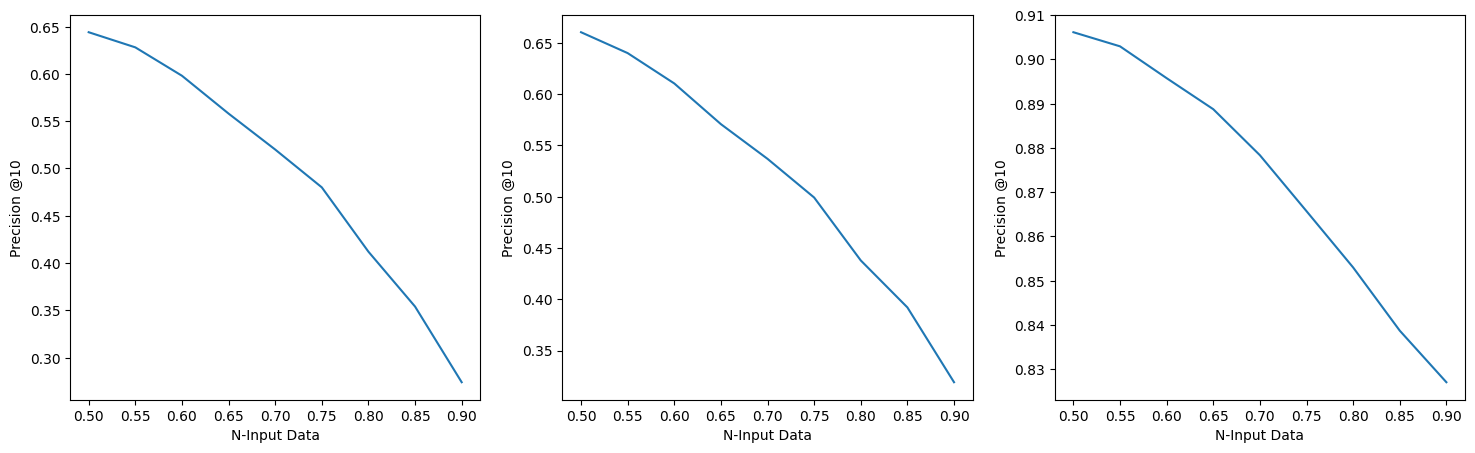

In [116]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1) 
plt.plot(list(avg_precision_score_ex1.keys()), list(avg_precision_score_ex1.values()))
plt.xlabel('N-Input Data')
plt.ylabel('Precision @10')

plt.subplot(1, 3, 2) 
plt.plot(list(avg_ndcg_score_ex1.keys()), list(avg_ndcg_score_ex1.values()))
plt.xlabel('N-Input Data')
plt.ylabel('Precision @10')

plt.subplot(1, 3, 3) 
plt.plot(list(avg_ils_score_ex1.keys()), list(avg_ils_score_ex1.values()))
plt.xlabel('N-Input Data')
plt.ylabel('Precision @10')

plt.show()

<h3>Experiment 2 - Get Evaluation for Normal Case</h3>
<blockquotes>It calculates the average of Precision, NDCG, and ILS for all users.</blockquotes>

In [117]:
# Parameter
n_recommendations_ex2 = [5, 10, 20]
n_target_data_ex2 = 0.50

In [118]:
# Split Listening Histories Data
listening_histories_dictionary = get_listening_histories_with_split(listening_histories, n_target_data_ex2)

In [119]:
precision_score_dict_ex2 = {}
ndcg_score_dict_ex2 = {}
ils_score_dict_ex2 = {}

for _, n_recommendation in enumerate(n_recommendations_ex2):
    precision_score = []
    ndcg_score = []
    ils_score = []
    for user_id, user_data in listening_histories_dictionary.items():
        user_history = user_data['input_data']
        
        recommended_musics = get_music_recommendation(entity_embeddings, musics_kdtree, user_history, k_similar_musics, musics)
        precision_score.append(precision(list(recommended_musics.keys()), user_data['target_data'], n_recommendation))
        ndcg_score.append(ndcg(list(recommended_musics.keys()), user_data['target_data'], n_recommendation))
        ils_score.append(ils(list(recommended_musics.keys()), entity_embeddings, n_recommendation))

    precision_score_dict_ex2[str(n_recommendation)] = precision_score
    ndcg_score_dict_ex2[str(n_recommendation)] = ndcg_score
    ils_score_dict_ex2[str(n_recommendation)] = ils_score

In [120]:
print('===== EXPERIMENT 2 - NORMAL CASE =====')
for key, value in precision_score_dict_ex2.items():
    print(f'Precision @{key} -> Lowest: {np.min(value)}, Highest: {np.max(value)}, Average: {np.mean(value)}')
print()

for key, value in ndcg_score_dict_ex2.items():
    print(f'NDCG @{key} -> Lowest: {np.min(value)}, Highest: {np.max(value)}, Average: {np.mean(value)}')
print()

for key, value in ils_score_dict_ex2.items():
    print(f'ILS @{key} -> Lowest: {np.min(value)}, Highest: {np.max(value)}, Average: {np.mean(value)}')

===== EXPERIMENT 2 - NORMAL CASE =====
Precision @5 -> Lowest: 0.0, Highest: 1.0, Average: 0.66
Precision @10 -> Lowest: 0.0, Highest: 1.0, Average: 0.644
Precision @20 -> Lowest: 0.0, Highest: 1.0, Average: 0.6

NDCG @5 -> Lowest: 0.0, Highest: 1.0, Average: 0.6751686200282179
NDCG @10 -> Lowest: 0.0, Highest: 1.0, Average: 0.6605043177155244
NDCG @20 -> Lowest: 0.0, Highest: 1.0, Average: 0.6275736867017124

ILS @5 -> Lowest: 0.6242261845240356, Highest: 0.9988473988888703, Average: 0.9273134743892401
ILS @10 -> Lowest: 0.6001851449482529, Highest: 0.9928463985746928, Average: 0.9061168180796801
ILS @20 -> Lowest: 0.5320646075082573, Highest: 0.9919319906754891, Average: 0.874463973764626


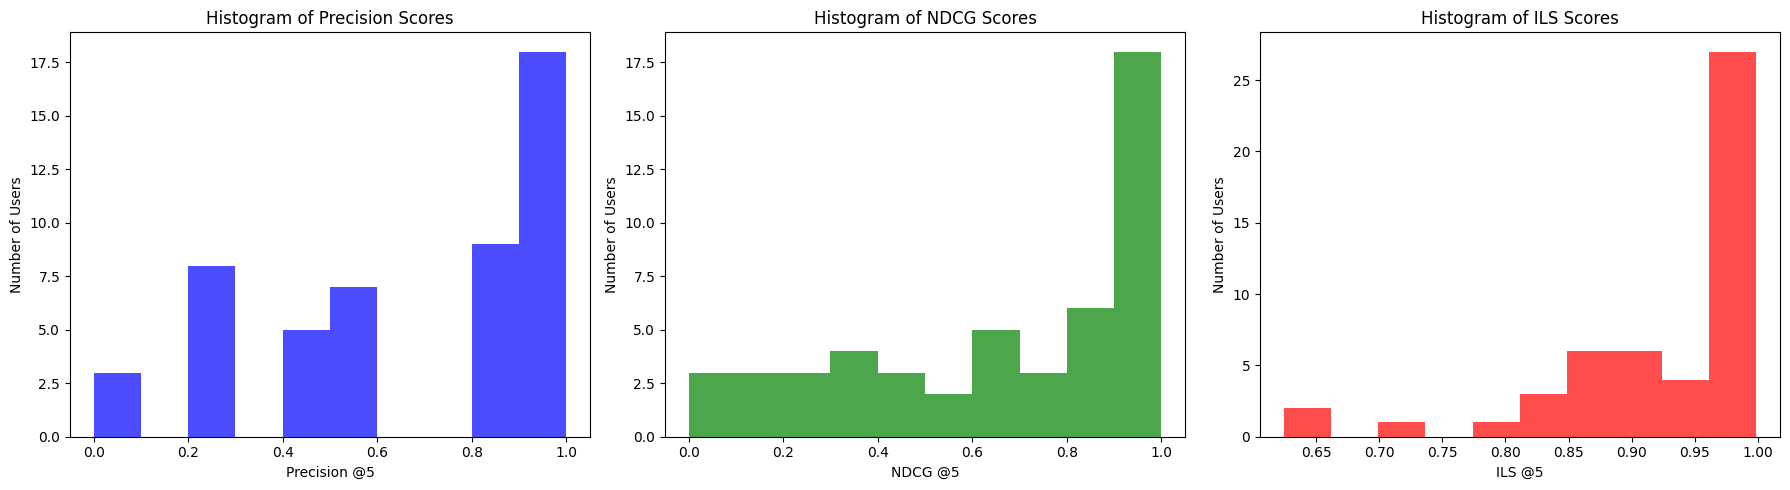

In [121]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1) 
plt.hist(precision_score_dict_ex2['5'], color='blue', alpha=0.7)
plt.title('Histogram of Precision Scores')
plt.xlabel('Precision @5')
plt.ylabel('Number of Users')

plt.subplot(1, 3, 2)
plt.hist(ndcg_score_dict_ex2['5'], color='green', alpha=0.7)
plt.title('Histogram of NDCG Scores')
plt.xlabel('NDCG @5')
plt.ylabel('Number of Users')

plt.subplot(1, 3, 3)  
plt.hist(ils_score_dict_ex2['5'], color='red', alpha=0.7)
plt.title('Histogram of ILS Scores')
plt.xlabel('ILS @5')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

<h3>Experiment 3 - Cold-Start Problems</h3>
<blockquotes>It calculates Precision, NDCG, and ILS in Cold-Start Environment when the users do not have a listening history</blockquotes>

In [122]:
# Get Random Users
n_sample_users = 10
sampled_users = df_listening_history['user_id'].drop_duplicates().sample(n=n_sample_users, random_state=2)
sampled_data = df_listening_history[df_listening_history['user_id'].isin(sampled_users)]

user_dict = {}
for user_id, group in sampled_data.groupby('user_id'):
    user_dict[user_id] = {
        'similar_user': '',
        'target_data': group['track_name'].tolist(),
    }

In [123]:
background_data = df_user_profile[df_user_profile['user_id'].isin(sampled_users)]

background_data.head(5)

,user_id,gender,age,country,background,background_id,relation
0,user_000001,m,NaN,Japan,m - nan - Japan,background_0,background_of
9,user_000181,f,19.0,United States,f - 19.0 - United States,background_9,background_of
13,user_000261,None,20.0,Norway,None - 20.0 - Norway,background_13,background_of
23,user_000465,f,NaN,Russian Federation,f - nan - Russian Federation,background_23,background_of
28,user_000567,f,NaN,Germany,f - nan - Germany,background_26,background_of


In [128]:
# Manipulate Columns For 'has_background' Relation
relation_has_background_cold = background_data.drop(['gender', 'age', 'country', 'background'], axis=1)
relation_has_background_cold.rename({'user_id': 'tail', 'background_id': 'head'}, axis=1, inplace=True)
relation_has_background_cold = relation_has_background_cold.iloc[:, [1, 0, 2]]

print(f'Number of Records: {len(background_data):,}\nUnique Users: {background_data.user_id.nunique()}\nAge Range: {background_data.age.min()} - {background_data.age.max()}\nUnique Countries: {background_data.country.nunique()}')
relation_has_background_cold.head(5)

Number of Records: 10
Unique Users: 10
Age Range: 19.0 - 20.0
Unique Countries: 6


,head,tail,relation
0,background_0,user_000001,background_of
9,background_9,user_000181,background_of
13,background_13,user_000261,background_of
23,background_23,user_000465,background_of
28,background_26,user_000567,background_of


In [129]:
triplets_cold = list(zip(relation_has_background_cold['head'], relation_has_background_cold['relation'], relation_has_background_cold['tail']))

entities_list = set([str(triplet[0]) for triplet in triplets_cold] + [str(triplet[2]) for triplet in triplets_cold])
relations_list = set([triplet[1] for triplet in triplets_cold])

# Initialize Embedding for Entities and Relations
initial_entities = initialize_embedding(entities_list, preparation_hp["dimension"])
initial_relations = initialize_embedding(relations_list, preparation_hp["dimension"])

# Normalize Embedding Using L2-Norm
entity_normalized = {entity: normalize_vector(embedding) for entity, embedding in initial_entities.items()}
relation_normalized = {relation: normalize_vector(embedding) for relation, embedding in initial_relations.items()}

new_entity_embeddings = {**entity_embeddings, **entity_normalized}
new_relation_embeddings = {**relation_embeddings, **relation_normalized}

grouped_triplet_cold = group_by_relation(triplets_cold, relations_list)
triplet_batches_cold = split_dataset(grouped_triplet_cold, preparation_hp['batch_size'])

new_entity_embeddings, new_relation_embeddings = transm_model(triplet_batches_cold, new_entity_embeddings, new_relation_embeddings, relation_weights, learning_rate=0.1, margin=1.0, epochs=100, n_neg_triplet=4)

Epoch 2/100, Batch: 1, Loss: 0 - Training stopped early.
✅ Embedding Completed!, Loss: 0, Average Loss: 0.0


In [130]:
users_new = list(users) + list(sampled_users)
users_new_embedding = [new_entity_embeddings[user] for user in users_new]
users_new_kdtree = KDTree(users_new_embedding)

In [131]:
# Get Most Similar User of Selected Users
for _, user in enumerate(list(sampled_users)):
  query = new_entity_embeddings[user].reshape(1, -1)
  similar_user = user
  i = 1

  while (similar_user == user or similar_user not in users):
    distances, indices = users_new_kdtree.query(query, k=i + 1)
    similar_user = users_new[indices[0][i]]
    i += 1

  user_dict[user]['similar_user'] = similar_user

print(user_dict)

{'user_000001': {'similar_user': 'user_000567', 'target_data': ['The Launching Of Big Face', 'One Life', 'Just Swing', 'The Story', 'Pontificate', 'Liquid Cherries', 'The Story', 'Pontificate', 'Waiting', 'Battery', 'Regina', "The Rich Man'S Prayer", 'Breathe', 'One Life', 'Just Swing', 'The Story', 'Pontificate', 'Waiting', 'Knowing', 'Knowing', 'Breathe', "The Rich Man'S Prayer", "The Rich Man'S Prayer", 'Breathe', 'Knowing', 'One Life', 'Just Swing', 'The Story', 'Pontificate', 'Waiting', 'Battery', 'Regina', "The Rich Man'S Prayer", 'Breathe', 'Knowing', 'One Life', 'Just Swing', 'The Story', 'Pontificate', 'Waiting', 'Battery', 'Regina', "The Rich Man'S Prayer", 'Waiting', 'Battery', 'Regina', 'Regina', 'All Hell Is Breaking Loose', 'Attack Ships On Fire', "Look What You'Re Doin' To Me (Feat. Phonte)", 'City Lights', 'Multiply', 'So Good Today', 'Get Silly', 'Multiply', 'Point Of No Return', 'Outnumbered']}, 'user_000181': {'similar_user': 'user_000261', 'target_data': ['Black Cof

In [138]:
precision_score_ex3 = []
ndcg_score_ex3 = []
ils_score_ex3 = []
for user_id, data in user_dict.items():
  similar_user = data['similar_user']  # Get the similar user
  similar_user_history_list = df_listening_history[df_listening_history['user_id'] == similar_user]['track_name'].tolist()
  similar_user_history = {music: index for index, music in enumerate(similar_user_history_list)}

  recommended_musics = get_music_recommendation(new_entity_embeddings, musics_kdtree, similar_user_history, k_similar_musics, musics)

  precision_score_ex3.append(precision(list(recommended_musics.keys()), data['target_data'], 20))
  ndcg_score_ex3.append(ndcg(list(recommended_musics.keys()), data['target_data'], 20))
  ils_score_ex3.append(ils(list(recommended_musics.keys()), new_entity_embeddings, 20))


In [139]:
print('===== EXPERIMENT 3 - COLD-START PROBLEM =====')
print(f'Precision @20 -> Lowest: {np.min(precision_score_ex3)}, Highest: {np.max(precision_score_ex3)}, Average: {np.mean(precision_score_ex3)}\n')
print(f'NDCG @20 -> Lowest: {np.min(ndcg_score_ex3)}, Highest: {np.max(ndcg_score_ex3)}, Average: {np.mean(ndcg_score_ex3)}\n')
print(f'ILS @20 -> Lowest: {np.min(ils_score_ex3)}, Highest: {np.max(ils_score_ex3)}, Average: {np.mean(ils_score_ex3)}\n')

===== EXPERIMENT 3 - COLD-START PROBLEM =====
Precision @20 -> Lowest: 0.0, Highest: 0.05, Average: 0.005

NDCG @20 -> Lowest: 0.0, Highest: 0.03233829114831982, Average: 0.003233829114831982

ILS @20 -> Lowest: 0.6635682770380857, Highest: 0.9567537339454888, Average: 0.817461530314249



<h3>Experiment 4 - Diversity Problems</h3>
<blockquotes>It calculates ILS Score for recommended musics before and after using Bounded Greedy Selection Algorithm</blockquotes>

In [140]:
# Parameter
n_considered_music_ex4 = 20
bound_diversity_ex4 = 5

In [141]:
ils_score_before = []
ils_score_after = []

# Diverisified Recommendation
for user_id, user_data in listening_histories_dictionary.items():
  user_history = user_data['input_data']
  
  recommended_musics = get_music_recommendation(entity_embeddings, musics_kdtree, user_history, k_similar_musics, musics)
  diverse_recommendation = diversified_recommendation(entity_embeddings, recommended_musics, bound_diversity_ex4, n_considered_music_ex4)

  ils_score_before.append(ils(list(recommended_musics.keys()), entity_embeddings, n_considered_music_ex4))
  ils_score_after.append(ils(list(diverse_recommendation.keys()), entity_embeddings, n_considered_music_ex4))

In [142]:
print('===== EXPERIMENT 4 - DIVERSITY PROBLEM =====')
print(f'ILS @20 (Before Diversified) -> Lowest: {np.min(ils_score_before)}, Highest: {np.max(ils_score_before)}, Average: {np.mean(ils_score_before)}\n')
print(f'ILS @20 (After Diversified) -> Lowest: {np.min(ils_score_after)}, Highest: {np.max(ils_score_after)}, Average: {np.mean(ils_score_after)}\n')

===== EXPERIMENT 4 - DIVERSITY PROBLEM =====
ILS @20 (Before Diversified) -> Lowest: 0.5320646075082573, Highest: 0.9919319906754891, Average: 0.874463973764626

ILS @20 (After Diversified) -> Lowest: 0.5241849573933436, Highest: 0.9925773367567998, Average: 0.8531719858587964



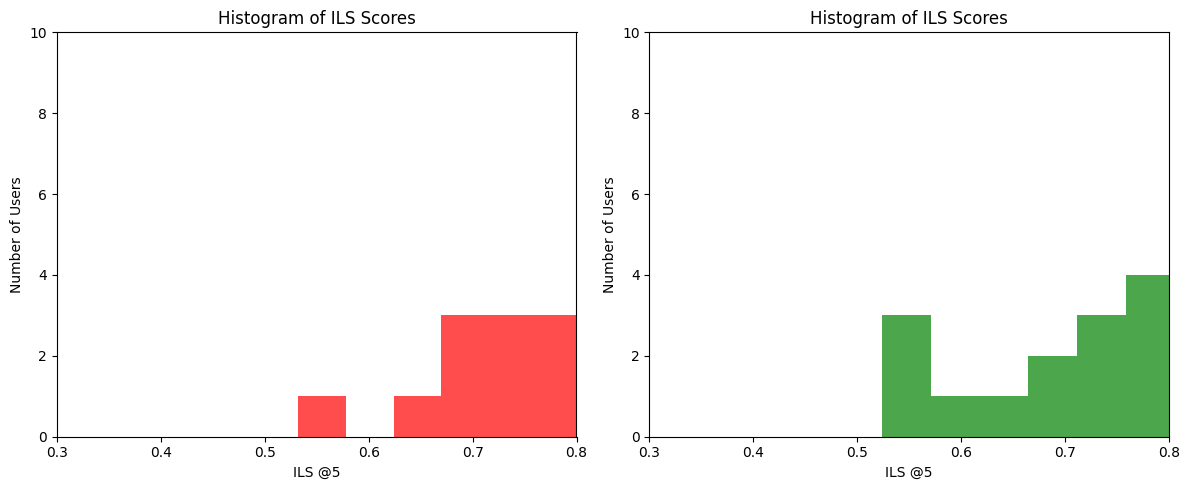

In [143]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ils_score_before, color='red', alpha=0.7)
plt.xlim(0.3, 0.8)
plt.ylim(0, 10)
plt.title('Histogram of ILS Scores')
plt.xlabel('ILS @5')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)  
plt.hist(ils_score_after, color='green', alpha=0.7)
plt.xlim(0.3, 0.8)
plt.ylim(0, 10)
plt.title('Histogram of ILS Scores')
plt.xlabel('ILS @5')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

In [144]:
ils_change = (np.mean(ils_score_after) - np.mean(ils_score_before)) * 100 / np.mean(ils_score_before)
print(ils_change)

-2.4348616460625827


<h3>Experiment 5 - Usage of Knowledge Graph</h3>
<blockquotes>It calculates Precision, NDCG, and ILS for recommendation resulted by knowledge graph and non-graph</blockquotes>

<h4>Relevancy Aspect</h4>

In [145]:
df_knn = df_listening_history_selected.groupby('user_id').head(100)

input_data = df_knn.groupby('user_id').head(50)
input_data.loc[:, ('interaction')] = 1

target_data = df_knn.groupby('user_id').tail(50)
target_data = target_data.groupby('user_id')['track_id'].apply(list).to_dict()

print(f'Number of Record: {len(input_data)}')
input_data.tail(5)

Number of Record: 2459


/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/4168311881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:, ('interaction')] = 1


,user_id,artist_id,artist_name,track_id,track_name,interaction
18889257,user_000989,9946e322-2eb6-43dd-ae66-dd28114f1522,Jeff Scott Soto,686c3933-9252-477c-8538-4e09e65fda7a,So This Is Love,1
18889368,user_000989,e3434cc7-d348-491a-9dc8-325af3d9086d,Jane'S Addiction,51524bc4-0a54-4a31-a6aa-eaf17359a994,Pig'S In Zen,1
18889222,user_000989,020bfbb4-05c3-4c86-b372-17825c262094,Audioslave,be847c5f-2508-41ea-9743-a9e78b72cde7,Bring 'Em Back Alive,1
18889195,user_000989,4dbf5678-7a31-406a-abbe-232f8ac2cd63,Bryan Adams,4745aced-ef76-4db7-93b1-4a63159dcf1c,Native Son,1
18889194,user_000989,5dedf5cf-a598-4408-9556-3bf3f149f3ba,Whitesnake,6587f45d-b154-4617-af14-215e7ec8e9e5,Can'T Go On,1


In [146]:
user_enc = LabelEncoder()
input_data.loc[:, ('user_id_enc')] = user_enc.fit_transform(input_data.loc[:,('user_id')])

track_enc = LabelEncoder()
input_data.loc[:, ('track_id_enc')] = track_enc.fit_transform(input_data.loc[:, ('track_id')])

input_data_matrix = input_data[['user_id_enc', 'track_id_enc', 'interaction']]
input_data_matrix.drop_duplicates(inplace=True)

user_track_matrix = input_data_matrix.pivot(index='user_id_enc', columns='track_id_enc', values='interaction').fillna(0)

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=200, n_jobs=-1)
knn.fit(user_track_matrix.T)


/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/1088492949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:, ('user_id_enc')] = user_enc.fit_transform(input_data.loc[:,('user_id')])
/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/1088492949.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:, ('track_id_enc')] = track_enc.fit_transform(input_data.loc[:, ('track_id')])
/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/10884

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=200)

In [147]:
def recommend_tracks_knn(track_id, track_enc, user_track_matrix, n_recommendations=5 ):
    track_idx = track_enc.transform([track_id])[0]
    
    _, indices = knn.kneighbors(user_track_matrix[track_idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    
    recommended_tracks = []
    
    for idx in indices.flatten()[1:]:
        recommended_track_id = track_enc.inverse_transform([idx])[0]
        recommended_tracks.append(recommended_track_id)
    
    return recommended_tracks

In [148]:
target_data = input_data.groupby('user_id')['track_id'].apply(list).to_dict()

n_recommendations = [5, 10, 20]

precision_score_dict = {}
ndcg_score_dict = {}
ils_score_dict = {}

grouped = input_data.groupby('user_id')['track_id']

for _, n_recommendation in enumerate(n_recommendations):
    precision_score = []
    ndcg_score = []
    ils_score = []

    for user in input_data['user_id'].unique():
        track_listening = grouped.get_group(user).to_list()
        recommendation = []

        for track in track_listening:
            recommended_musics = recommend_tracks_knn(track, track_enc, user_track_matrix, n_recommendation)
            recommendation.extend(recommended_musics)

        recommendation_dict = dict(Counter(recommendation))
        sorted_dict = dict(sorted(recommendation_dict.items(), key=lambda item: item[1]))
        
        precision_score.append(precision(list(sorted_dict.keys()), target_data[user], n_recommendation))
        ndcg_score.append(ndcg(list(sorted_dict.keys()), target_data[user], n_recommendation))
        ils_score.append(ils_knn(list(sorted_dict.keys()), user_track_matrix, track_enc, n_recommendation))

    precision_score_dict[str(n_recommendation)] = precision_score
    ndcg_score_dict[str(n_recommendation)] = ndcg_score
    ils_score_dict[str(n_recommendation)] = ils_score

In [149]:
print('===== EXPERIMENT 5 - NON-GRAPH RECOMMENDATION SYSTEM =====')
for key, value in precision_score_dict.items():
    print(f'Precision @{key} -> Lowest: {np.min(value)}, Highest: {np.max(value)}, Average: {np.mean(value)}')
print()

for key, value in ndcg_score_dict.items():
    print(f'NDCG @{key} -> Lowest: {np.min(value)}, Highest: {np.max(value)}, Average: {np.mean(value)}')
print()

for key, value in ils_score_dict.items():
    print(f'ILS @{key} -> Lowest: {np.min(value)}, Highest: {np.max(value)}, Average: {np.mean(value)}')
print()

===== EXPERIMENT 5 - NON-GRAPH RECOMMENDATION SYSTEM =====
Precision @5 -> Lowest: 0.0, Highest: 1.0, Average: 0.272
Precision @10 -> Lowest: 0.0, Highest: 1.0, Average: 0.24599999999999997
Precision @20 -> Lowest: 0.0, Highest: 1.0, Average: 0.205

NDCG @5 -> Lowest: 0.0, Highest: 1.0, Average: 0.26690382684493735
NDCG @10 -> Lowest: 0.0, Highest: 1.0, Average: 0.24708139182769098
NDCG @20 -> Lowest: 0.0, Highest: 1.0, Average: 0.2070260565749841

ILS @5 -> Lowest: 0.0, Highest: 1.0, Average: 0.3022426406871193
ILS @10 -> Lowest: 0.10729838054991533, Highest: 1.0, Average: 0.3200424241908911
ILS @20 -> Lowest: 0.05672723470027382, Highest: 1.0, Average: 0.2506300167975711



<h4>Cold-Start Case</h4>

In [150]:
# Get Random Users
n_sample_users = 10
sampled_users = df_listening_history['user_id'].drop_duplicates().sample(n=n_sample_users, random_state=1)
sampled_data = df_listening_history[df_listening_history['user_id'].isin(sampled_users)]
sampled_data['interaction'] = 1

user_dict = {}
for user_id, group in sampled_data.groupby('user_id'):
    user_dict[user_id] = {
        'similar_user': '',
        'target_data': group['track_id'].tolist(),
    }

print(user_dict)

{'user_000041': {'similar_user': '', 'target_data': ['aefdb9f2-e479-4e4e-99b1-1567833748a9', '40d72a22-4df0-428b-9fdd-d815d30176cc', '9c8499e3-0914-4662-9afb-7f90c021d064', 'f9f0fd01-a55b-481e-924e-ce8adbacc12d', '1a881e9f-4cc7-40a1-8c1c-40861acf385c', '6930fb62-396a-4ae6-9019-e2b1656188fa', '02d9a285-8568-4bfb-a903-7dc7359ad008', '8035919e-d663-4e3e-a739-f944f635444f', 'aef17424-11b7-484d-92e5-3dc2c323875b', 'db0f5b6f-622b-49ea-85b9-c37b126fbfb6', '5f5fc497-08f3-4966-ae4f-cf5eeb4e2650', 'f390f5cc-8964-4a83-b342-49ba0252ff81', '123f4da0-d51c-4d9b-9a0b-6a7091e6c4c1', '2d83b822-da85-4ca3-a813-2a36a37f06a5', '320c3521-d3d4-4671-b6c0-93e939b01fbf', 'd267d16b-a387-4085-8bc7-1bc416807445', 'c2226239-a703-4433-bae3-b9421ed553b3', '4e16283f-62a1-401b-9789-ffe15262258d', '6e0dc45a-0a3e-4333-9698-9c117e0ffba7', '7750b3a2-b167-47db-ac21-ce7533c986f4', '7f5c30d0-0691-4a93-b158-5673526078f5', '543d2ede-7f7e-4209-921d-de2caad5fa90', 'a863e9a9-1ed2-400a-9510-7650ce0c8b55', '4fc92a4d-9b28-4f07-b62e-57

/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/1535075298.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['interaction'] = 1


In [151]:
input_data_clean = input_data.drop(['user_id_enc', 'track_id_enc'], axis=1)
input_data_cold = pd.concat([input_data_clean, sampled_data])

input_data_cold = input_data_cold.join(df_user_profile_full.set_index('user_id'), on='user_id')

input_data_cold['background'] = input_data_cold.apply(lambda row: f"{row['gender']} - {row['age']} - {row['country']}", axis=1)
input_data_cold['background_id'] = pd.factorize(input_data_cold['background'])[0]
input_data_cold['background_id'] = 'background_' + input_data_cold['background_id'].astype(str)

input_data_cold.head(5)

,user_id,artist_id,artist_name,track_id,track_name,interaction,gender,age,country,background,background_id
0,user_000001,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,c4633ab1-e715-477f-8685-afa5f2058e42,The Launching Of Big Face,1,m,NaN,Japan,m - nan - Japan,background_0
11115,user_000001,0a6eb633-fb2c-4683-9783-58c4e86ea740,The Matthew Herbert Big Band,d7e0d2ac-9ce8-4ef8-8716-37f546eb3d23,One Life,1,m,NaN,Japan,m - nan - Japan,background_0
11116,user_000001,0a6eb633-fb2c-4683-9783-58c4e86ea740,The Matthew Herbert Big Band,7cab875f-7d2a-4f01-ad4f-0597c779427c,Just Swing,1,m,NaN,Japan,m - nan - Japan,background_0
11117,user_000001,0a6eb633-fb2c-4683-9783-58c4e86ea740,The Matthew Herbert Big Band,110727dd-c03e-4855-bd50-db706c6893db,The Story,1,m,NaN,Japan,m - nan - Japan,background_0
11118,user_000001,0a6eb633-fb2c-4683-9783-58c4e86ea740,The Matthew Herbert Big Band,23b04828-ab15-46c3-b2fe-4bcdad1474a0,Pontificate,1,m,NaN,Japan,m - nan - Japan,background_0


In [152]:
user_enc = LabelEncoder()
input_data_cold.loc[:, ('user_id_enc')] = user_enc.fit_transform(input_data_cold.loc[:,('user_id')])

track_enc = LabelEncoder()
input_data_cold.loc[:, ('track_id_enc')] = track_enc.fit_transform(input_data_cold.loc[:, ('track_id')])

background_enc = LabelEncoder()
input_data_cold.loc[:, ('background_id_enc')] = background_enc.fit_transform(input_data_cold.loc[:, ('background_id')])

input_user_background_matrix = input_data_cold[['user_id_enc', 'background_id_enc', 'interaction']]
input_user_background_matrix.drop_duplicates(inplace=True)

input_user_track_matrix = input_data_cold[['user_id_enc', 'track_id_enc', 'interaction']]
input_user_track_matrix.drop_duplicates(inplace=True)

user_background_matrix = input_user_background_matrix.pivot(index='background_id_enc', columns='user_id_enc', values='interaction').fillna(0)
user_track_matrix = input_user_track_matrix.pivot(index='user_id_enc', columns='track_id_enc', values='interaction').fillna(0)

knn_similar_user = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=2, n_jobs=-1)
knn_similar_user.fit(user_background_matrix.T)

knn_similar_track = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=200, n_jobs=-1)
knn_similar_track.fit(user_track_matrix.T)

/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/754320773.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_user_background_matrix.drop_duplicates(inplace=True)
/var/folders/l_/9ctj57sj4sg2b6h_790rw62r0000gn/T/ipykernel_17639/754320773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_user_track_matrix.drop_duplicates(inplace=True)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=200)

In [153]:
def recommend_tracks_knn_cold(track_id, track_enc, user_track_matrix, n_recommendations=5 ):
    track_idx = track_enc.transform([track_id])[0]
    
    _, indices = knn_similar_track.kneighbors(user_track_matrix[track_idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    
    recommended_tracks = []
    
    for idx in indices.flatten()[1:]:
        recommended_track_id = track_enc.inverse_transform([idx])[0]
        recommended_tracks.append(recommended_track_id)
    
    return recommended_tracks

def similar_user_knn(user_id, user_enc, background_user_matrix, n_recommendations=2):
    track_idx = user_enc.transform([user_id])[0]
    
    _, indices = knn_similar_user.kneighbors(background_user_matrix[track_idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    
    similar_user = []
    
    for idx in indices.flatten()[1:]:
        similar_user_id = user_enc.inverse_transform([idx])[0]
        similar_user.append(similar_user_id)
    
    return similar_user

In [154]:
for user, attributes in user_dict.items():
  similar_user = similar_user_knn(user, user_enc, user_background_matrix, 2)
  attributes['similar_user'] = similar_user[0]

print(user_dict)

{'user_000041': {'similar_user': 'user_000021', 'target_data': ['aefdb9f2-e479-4e4e-99b1-1567833748a9', '40d72a22-4df0-428b-9fdd-d815d30176cc', '9c8499e3-0914-4662-9afb-7f90c021d064', 'f9f0fd01-a55b-481e-924e-ce8adbacc12d', '1a881e9f-4cc7-40a1-8c1c-40861acf385c', '6930fb62-396a-4ae6-9019-e2b1656188fa', '02d9a285-8568-4bfb-a903-7dc7359ad008', '8035919e-d663-4e3e-a739-f944f635444f', 'aef17424-11b7-484d-92e5-3dc2c323875b', 'db0f5b6f-622b-49ea-85b9-c37b126fbfb6', '5f5fc497-08f3-4966-ae4f-cf5eeb4e2650', 'f390f5cc-8964-4a83-b342-49ba0252ff81', '123f4da0-d51c-4d9b-9a0b-6a7091e6c4c1', '2d83b822-da85-4ca3-a813-2a36a37f06a5', '320c3521-d3d4-4671-b6c0-93e939b01fbf', 'd267d16b-a387-4085-8bc7-1bc416807445', 'c2226239-a703-4433-bae3-b9421ed553b3', '4e16283f-62a1-401b-9789-ffe15262258d', '6e0dc45a-0a3e-4333-9698-9c117e0ffba7', '7750b3a2-b167-47db-ac21-ce7533c986f4', '7f5c30d0-0691-4a93-b158-5673526078f5', '543d2ede-7f7e-4209-921d-de2caad5fa90', 'a863e9a9-1ed2-400a-9510-7650ce0c8b55', '4fc92a4d-9b28-4

In [155]:
target_data_cold = input_data.groupby('user_id')['track_id'].apply(list).to_dict()

precision_score_ex5 = []
ndcg_score_ex5 = []
ils_score_ex5 = []

for user_id, data in user_dict.items():
    similar_user = data['similar_user']  # Get the similar user
    similar_user_history_list = input_data_cold[input_data_cold['user_id'] == similar_user]['track_id'].tolist()
    recommendation = []

    for track in similar_user_history_list:
        recommended_musics = recommend_tracks_knn_cold(track, track_enc, user_track_matrix, 20)
        recommendation.extend(recommended_musics)


    recommendation_dict = dict(Counter(recommendation))
    sorted_dict = dict(sorted(recommendation_dict.items(), key=lambda item: item[1]))
    
    precision_score_ex5.append(precision(list(sorted_dict.keys()), data['target_data'], 20))
    ndcg_score_ex5.append(ndcg(list(sorted_dict.keys()), data['target_data'], 20))
    ils_score_ex5.append(ils_knn(list(sorted_dict.keys()), user_track_matrix, track_enc, 20))

In [156]:
print('===== EXPERIMENT 5 - COLD-START PROBLEM =====')
print(f'Precision @20 -> Lowest: {np.min(precision_score_ex5)}, Highest: {np.max(precision_score_ex5)}, Average: {np.mean(precision_score_ex5)}\n')
print(f'NDCG @20 -> Lowest: {np.min(ndcg_score_ex5)}, Highest: {np.max(ndcg_score_ex5)}, Average: {np.mean(ndcg_score_ex5)}\n')
print(f'ILS @20 -> Lowest: {np.min(ils_score_ex5)}, Highest: {np.max(ils_score_ex5)}, Average: {np.mean(ils_score_ex5)}\n')

===== EXPERIMENT 5 - COLD-START PROBLEM =====
Precision @20 -> Lowest: 0.0, Highest: 0.5, Average: 0.085

NDCG @20 -> Lowest: 0.0, Highest: 0.5061719015257574, Average: 0.08939734211626996

ILS @20 -> Lowest: 0.06462197154237909, Highest: 1.0, Average: 0.28216457809063583



<h2>Hyperparameter Tuning</h2>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator
import numpy as np

class TransMWrapper(BaseEstimator):
    def __init__(self, entity_embeddings, relation_embeddings, relation_weights, learning_rate=0.01, margin=1.0, epochs=100, n_neg_triplet=10):
        self.entity_embeddings = entity_embeddings
        self.relation_embeddings = relation_embeddings
        self.relation_weights = relation_weights
        self.learning_rate = learning_rate
        self.margin = margin
        self.epochs = epochs
        self.n_neg_triplet = n_neg_triplet

    def fit(self, all_triplets):
        transm_model(all_triplets, self.entity_embeddings, self.relation_embeddings, self.relation_weights, 
                     self.learning_rate, self.margin, self.epochs, self.n_neg_triplet)
        return self

    def score(self, X, y=None):
        total_loss = 0
        for triplet in X:
            head, relation, tail = triplet
            positive_score = _get_score(self.entity_embeddings[head], self.relation_embeddings[relation], self.entity_embeddings[tail], self.relation_weights[relation])
            negative_triplet = _generate_negative_triplet(triplet, self.entity_embeddings)
            negative_score = _get_score(self.entity_embeddings[negative_triplet[0]], self.relation_embeddings[negative_triplet[1]], 
                                        self.entity_embeddings[negative_triplet[2]], self.relation_weights[relation])
            total_loss += _get_loss(self.margin, positive_score, negative_score)
        return -total_loss  # Return negative loss because GridSearchCV tries to maximize the score

# Use RandomizedSearchCV for Hyperparameter Tuning
def hyperparameter_tuning(entity_embeddings, relation_embeddings, relation_weights, all_triplets):
    param_distributions = {
        'learning_rate': [0.01, 0.05, 0.1],
        'margin': [0.1, 0.5, 1.0],
        'epochs': [50, 100, 200],
        'n_neg_triplet': [2, 6, 10]
    }
    
    model = TransMWrapper(entity_embeddings=entity_embeddings, relation_embeddings=relation_embeddings, relation_weights=relation_weights)

    random_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=10, cv=3, random_state=42, scoring='neg_mean_squared_error')
    random_search.fit(all_triplets)
    print(f"Best Hyperparameters: {random_search.best_params_}")
    
    return random_search.best_estimator_

best_model = hyperparameter_tuning(entity_embeddings, relation_embeddings, relation_weights, triplet_batches)
